In [1]:
from src import data_loader as dl
from src.data_loader import PVDataLoader
from src.models import ExactGPModel
from src.variational_dist import VariationalBase
from src.beta_likelihood import BetaLikelihood
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from src.plotting import plot_grid, plot_gp, plot_train_test_split, plot_acf_pacf

/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Steps

In [22]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 19 m : 13 sec



In [3]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16

In [25]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location=df_location, 
                                         df_pv=df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv=df_pv,
                                 threshold=THRESHOLD)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv=df_pv,
                            day_min=DAY_MIN,
                            day_max=DAY_MAX)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv=df_pv,
                                  thresh=THRESHOLD)


Dropping 54 systems producing over night


In [26]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                         df_location=df_location)
df_pv['datetime'] = datetime

In [27]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [2]:
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.75
COORDS = (55.55074, -4.3278)

In [4]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 13 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [5]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [6]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

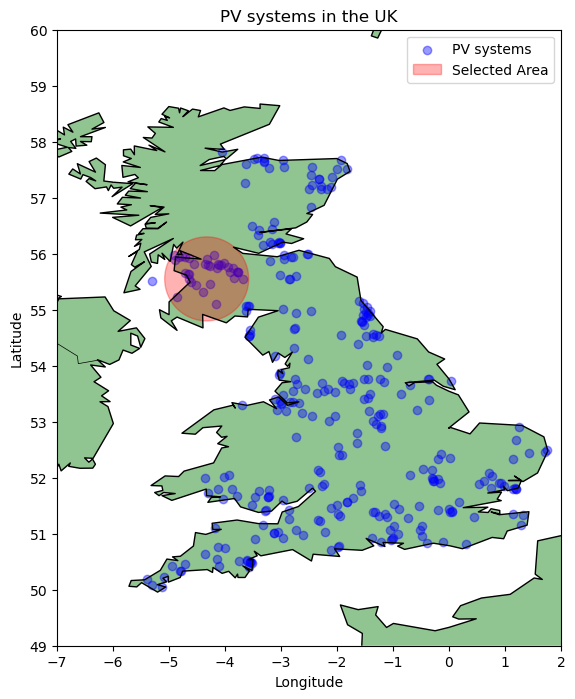

In [7]:
from src.plotting import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [596]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=10,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')



==> Loading data
==> Loaded data in: 0 m : 10 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [597]:
time, y = loader.get_time_series()

In [598]:
time_train, y_train, time_test, y_test = dl.train_test_split(time, y, n_hours=3)

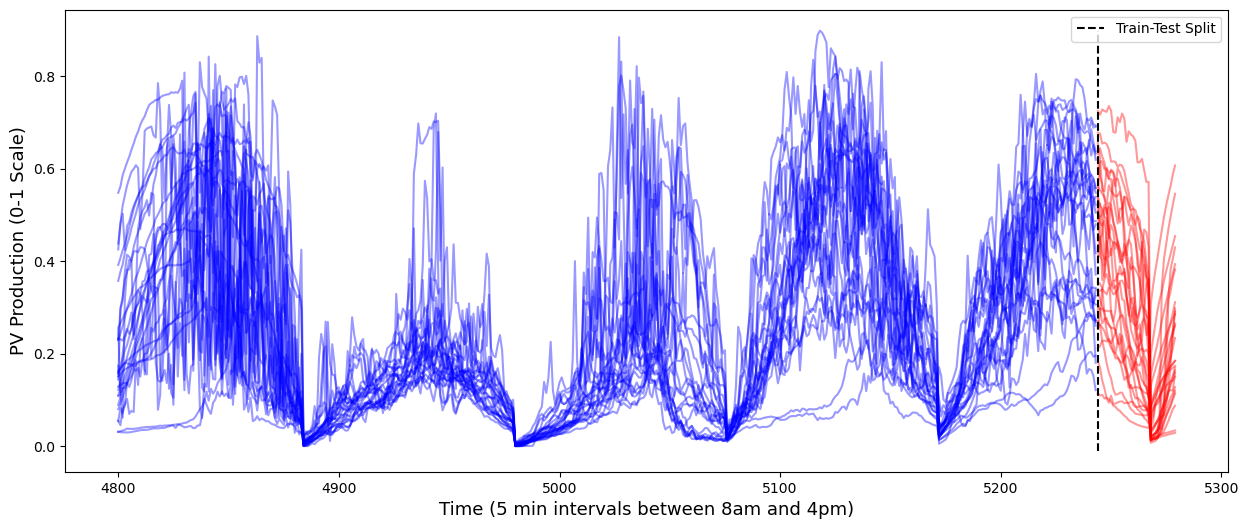

In [599]:
plot_train_test_split(time_train, time_test, y_train, y_test)

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

In [854]:
from typing import Any, Optional
import torch
from torch import Tensor
from torch.distributions import Beta
from gpytorch.constraints import Interval, Positive
from gpytorch.priors import Prior
from gpytorch.likelihoods import _OneDimensionalLikelihood



class BetaLikelihood(_OneDimensionalLikelihood):
    """
    A Beta likelihood for regressing over percentages.

    The Beta distribution is parameterized by :math:`\alpha > 0` and :math:`\beta > 0` parameters
    which roughly correspond to the number of prior positive and negative observations.
    We instead parameterize it through a mixture :math:`m \in [0, 1]` and scale :math:`s > 0` parameter.

    .. math::
        \begin{equation*}
            \alpha = ms, \quad \beta = (1-m)s
        \end{equation*}

    The mixture parameter is the output of the GP passed through a logit function :math:`\sigma(\cdot)`.
    The scale parameter is learned.

    .. math::
        p(y \mid f) = \text{Beta} \left( \sigma(f) s , (1 - \sigma(f)) s\right)

    Args:
        batch_shape (torch.Size, optional): The batch shape of the likelihood. Default: torch.Size([])
        scale_prior (Prior, optional): Prior over the scale parameter (default: None).
        scale_constraint (Interval, optional): Constraint to place over the scale parameter (default: Interval(0, 1)).
    """

    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([]),
        scale_prior: Optional[Prior] = None,
        scale_constraint: Optional[Interval] = None,
    ) -> None:
        super().__init__()

        if scale_constraint is None:
            scale_constraint = Positive()

        self.raw_scale = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        if scale_prior is not None:
            self.register_prior("scale_prior", scale_prior, lambda m: m.scale, lambda m, v: m._set_scale(v))

        self.register_constraint("raw_scale", scale_constraint)

    @property
    def scale(self) -> Tensor:
        return self.raw_scale_constraint.transform(self.raw_scale)

    @scale.setter
    def scale(self, value: Tensor) -> None:
        self._set_scale(value)

    def _set_scale(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_scale)
        self.initialize(raw_scale=self.raw_scale_constraint.inverse_transform(value))    

    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> Beta:
        
        # Map function samples to the range [0, 1] 
        # TODO explore other methods than sigmoid
        mapped_samples = torch.tanh(function_samples) / 2 + 0.5

        # probit link function
        # mapped_samples = torch.erf(function_samples / 2 ** 0.5) 

        self.alpha = self.scale * mapped_samples 
        self.beta = self.scale - self.alpha

        # return Beta(concentration1=self.alpha, concentration0=self.beta)
        
        return Beta(concentration1=self.alpha.exp(), concentration0=self.beta.exp())



In [855]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, MeanFieldVariationalDistribution, UnwhitenedVariationalStrategy
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel, PeriodicKernel, ProductKernel, AdditiveKernel, RBFKernel
from gpytorch.means import ConstantMean, ZeroMean, LinearMean
from gpytorch.distributions import MultivariateNormal
import torch
import gpytorch

# TODO test MeanFieldVariationalDistribution
# TODO test UnwhitenedVariationalStrategy
# TODO test different kernels
# TODO test different likelihoods
# TODO add confidence region for beta likelihood
# TODO config to work for unwhitened, natural, and tril natural
# TODO create fit function for natural variational distribution

class ApproximateGPBaseModel(ApproximateGP):
    """ 
    Base model for performing inference with a Gaussian Process (GP) using
    stochastic variational inference (SVI) with inducing points which can be
    scaled to large datasets. 
    
    For a guide to GPs and SVI, see the following paper:
    https://arxiv.org/abs/1309.6835

    Args:
        train_x (torch.Tensor): training data
        likelihood (gpytorch.likelihoods.Likelihood): likelihood
        variational_distribution (gpytorch.variational.VariationalDistribution): variational distribution
    """

    def __init__(self, train_x : torch.Tensor, 
                 likelihood : gpytorch.likelihoods.Likelihood, 
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel,
                 config : dict,
                 jitter : float = 1e-4,
                 learn_inducing_locations : bool = False
                 ):
        variational_distribution = VariationalBase(config).variational_distribution
        variational_strategy = VariationalStrategy(self, 
                                                   inducing_points=train_x, 
                                                   variational_distribution=variational_distribution,
                                                   learn_inducing_locations=learn_inducing_locations,
                                                   jitter_val=jitter) 
        
        super(ApproximateGPBaseModel, self).__init__(variational_strategy)
        
        # TODO change this to accept exogenous variables
        
        dims = 1 if len(train_x.shape) == 1 else train_x.shape[1]
        
        self.mean_module = mean_module
        self.covar_module = covar_module
        self.likelihood = likelihood
    
    def forward(self, x):
        """ 
        Model prediction of the GP model

        Args:
            x (torch.Tensor): input data
        
        Returns:
            latent_u (gpytorch.distributions.MultivariateNormal): GP model 
                                                                   f(x), where f ~ GP( m(x), k(x, x))
        """
        
        mu = self.mean_module(x)
        k = self.covar_module(x)

        return MultivariateNormal(mu, k)
        
    def fit(self, 
            n_iter : int, 
            lr : float,
            optim : torch.optim.Optimizer,
            device : torch.device, verbose : bool = True):
        """
        Train the GP model using SVI

        Args:
            n_iter (int): number of iterations
            lr (float): learning rate
            optim (str): optimizer
            device (torch.device): device to train on
            verbose (bool): whether to print training progress
        """
        self.to(device)
        
        self.train()
        self.likelihood.train()

        optimizer = optim(self.parameters(), lr=lr)
        elbo = gpytorch.mlls.VariationalELBO(likelihood=self.likelihood, 
                                            model=self, 
                                            num_data=self.y.size(0))
        
        print_freq = n_iter // 10
        self.losses = []
        
        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X)
            loss = -elbo(output, self.y)
            loss.backward()
            optimizer.step()

            self.losses.append(loss.item())

            if verbose and (i+1) % print_freq == 0:
                print(f'Iter {i+1}/{n_iter} - Loss: {loss.item():.3f}')
    
    def predict(self, X : torch.Tensor, device : torch.device):
        """ 
        Make predictions with the GP model

        Args:
            X (torch.Tensor): test data
            device (torch.device): device to make predictions on

        Returns:
            preds (gpytorch.distributions.MultivariateNormal): predictive mean and variance
        """
        self.eval()
        self.likelihood.eval()
        
        self.to(device)
        self.likelihood.to(device)

        with torch.no_grad():
           
            if not isinstance(self.likelihood, GaussianLikelihood):
                with gpytorch.settings.num_likelihood_samples(30):
                    preds = self.likelihood(self(X)) 
            else:
                preds = self.likelihood(self(X))
            
        return preds

class GaussianGP(ApproximateGPBaseModel):
    """ 
    Stochastic Variational Inference GP model for regression using
    inducing points for scalability and a Gaussian likelihood for unbounded outputs

    Args:
        inducing_points (torch.Tensor): inducing points
        variational_dist (gpytorch.variational.VariationalDistribution): variational distribution
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module
    """
    def __init__(self, 
                 X : torch.Tensor, 
                 y : torch.Tensor, 
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel,
                 config : dict,
                 jitter : float = 1e-6,
                 ):
        
        super(GaussianGP, self).__init__(train_x=X, 
                                         likelihood=GaussianLikelihood(), 
                                         mean_module=mean_module,
                                         covar_module=covar_module,
                                         config=config,
                                         jitter=jitter)
        self.X = X
        self.y = y

class BetaGP(ApproximateGPBaseModel):
    """ 
    Stochastic Variational Inference GP model for regression using
    inducing points for scalability and a Beta likelihood for bounded outputs
    in the range [0, 1]

    Args:
        inducing_points (torch.Tensor): inducing points
        variational_dist (gpytorch.variational.VariationalDistribution): variational distribution
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module
    """
    def __init__(self, 
                 X : torch.Tensor, 
                 y : torch.Tensor,
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel,
                 config : dict,
                 jitter : float = 1e-4,
                 ):
        
        assert y.min() >= 0 and y.max() <= 1, 'y must be in the range [0, 1] for Beta likelihood'
        
        # add perturbation to the data to avoid numerical issues for bounded outputs
        if y.min() == 0:
            y += jitter
        
        if y.max() == 1:
            y -= jitter
        
        super(BetaGP, self).__init__(train_x=X,
                                     likelihood=BetaLikelihood(), 
                                     mean_module=mean_module,
                                     covar_module=covar_module,
                                     config=config,
                                     jitter=jitter)
        self.X = X
        self.y = y

In [856]:
time, y = loader.get_time_series()
idx = 6
y_in = y[:, idx]

x_train, y_train, x_test, y_test = dl.train_test_split(time, y_in, n_hours=3)

idx = np.random.choice(x_train.shape[0], 350, replace=False)
x_inducing = x_train[idx]
y_inducing = y_train[idx]

In [857]:
# TODO add a prior to the lengthscale in matern, and the period in periodic
lmbda = 10
matern = MaternKernel(nu=3/2, 
                      ard_num_dims=1)
quasi_periodic = ProductKernel(MaternKernel(nu=3/2), PeriodicKernel())
scaled_additive = ScaleKernel(AdditiveKernel(matern, quasi_periodic))

In [866]:
config = {
    'type': 'stochastic',
    'name': 'mean_field',
    'num_inducing_points': x_inducing.size(0),
    'mean_init_std': 1e-4,
}

model_beta = BetaGP(X=x_inducing, 
               y=y_inducing,
               mean_module=ConstantMean(),
               covar_module=ScaleKernel(scaled_additive),
               config=config,
               jitter=1e-10
                )
model_beta.fit(n_iter=250, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))
                     

Iter 25/250 - Loss: -0.439
Iter 50/250 - Loss: -0.759
Iter 75/250 - Loss: -1.071
Iter 100/250 - Loss: -1.189
Iter 125/250 - Loss: -1.218
Iter 150/250 - Loss: -1.219
Iter 175/250 - Loss: -1.219
Iter 200/250 - Loss: -1.219
Iter 225/250 - Loss: -1.223
Iter 250/250 - Loss: -1.221


In [867]:
# find scale parameter of kernel of model_beta

print(f'Matern lengthscale parameter: {model_beta.covar_module.base_kernel.lengthscale.item():.3f}')
print(f'Scale parameter: {model_beta.covar_module.outputscale.item():.3f}')
print(f'Constant Mean: {model_beta.mean_module.constant.item():.3f}')
print(f'likelihood scale: {model_beta.likelihood.scale.item():.3f}')

# print(f'Noise Parameter: {model_beta.likelihood.noise.item():.3f}')

AttributeError: 'NoneType' object has no attribute 'item'

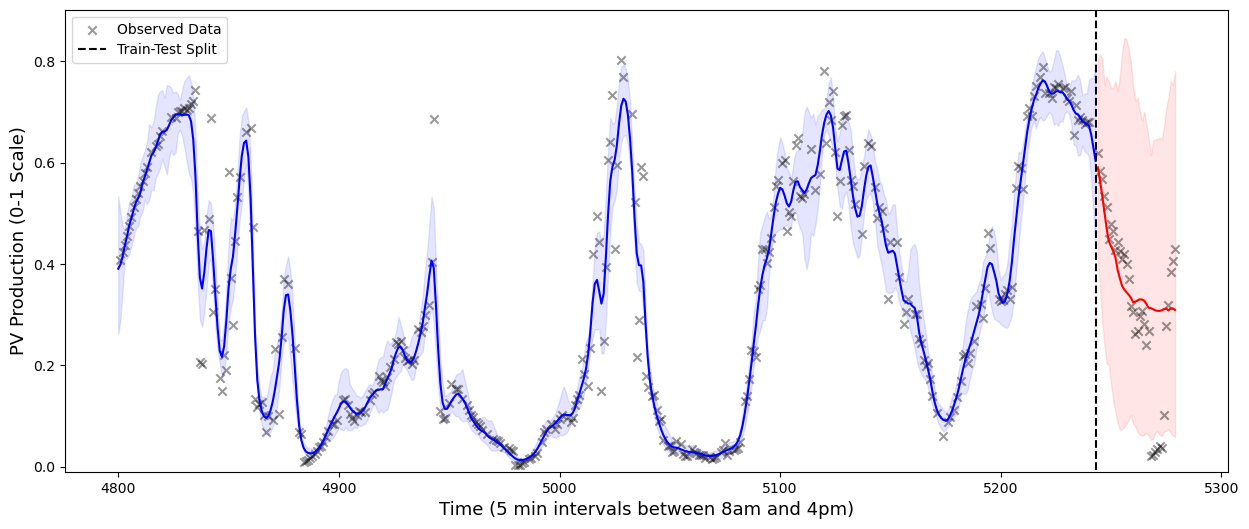

In [868]:
plot_gp(model_beta, x_train, x_test, y_train, y_test, x_inducing, y_inducing)

In [861]:
print('alpha range: ', model_beta.likelihood.alpha.min().item(), model_beta.likelihood.alpha.max().item())
print('beta range: ', model_beta.likelihood.beta.min().item(), model_beta.likelihood.beta.max().item())

alpha range:  1.1924431324005127 2.829235076904297
beta range:  1.7726211547851562 3.4094130992889404


In [673]:
config = {
    'type': 'stochastic',
    'name': 'cholesky',
    'num_inducing_points': x_inducing.size(0),
    'mean_init_std': 1e-3,
}

model_gaussian_svi = GaussianGP(X=x_inducing, 
                   y=y_inducing,
                   mean_module=ConstantMean(),
                   covar_module=ScaleKernel(scaled_additive),
                   config=config,
                   jitter=1e-3
                   )
model_gaussian_svi.fit(n_iter=250, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))

Iter 25/250 - Loss: -0.087
Iter 50/250 - Loss: -0.802
Iter 75/250 - Loss: -0.843
Iter 100/250 - Loss: -0.849
Iter 125/250 - Loss: -0.850
Iter 150/250 - Loss: -0.851
Iter 175/250 - Loss: -0.851
Iter 200/250 - Loss: -0.845
Iter 225/250 - Loss: -0.796
Iter 250/250 - Loss: -0.834


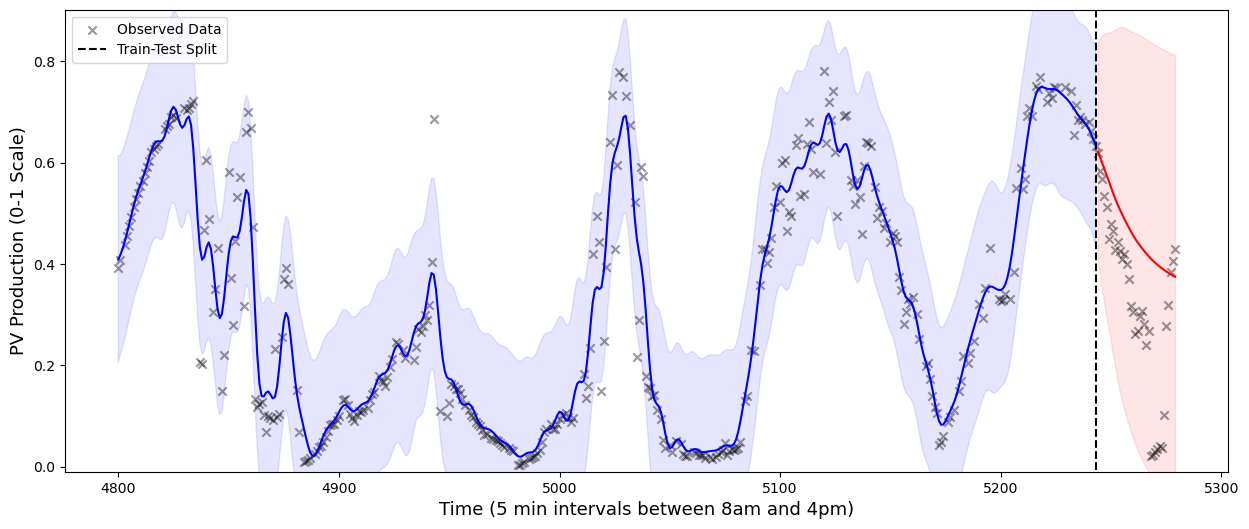

In [674]:
plot_gp(model_gaussian_svi, x_train, x_test, y_train, y_test,  x_inducing, y_inducing)

In [675]:
model_exact = ExactGPModel(X=x_train,
                           y=y_train,
                           likelihood=GaussianLikelihood(),
                           mean_module=ConstantMean(),
                           covar_module=ScaleKernel(scaled_additive))
model_exact.fit(n_iter=250, lr=0.1, optim='Adam')


Iter 25/250 - Loss: -0.183
Iter 50/250 - Loss: -0.934
Iter 75/250 - Loss: -0.972
Iter 100/250 - Loss: -0.987
Iter 125/250 - Loss: -1.006
Iter 150/250 - Loss: -1.056
Iter 175/250 - Loss: -1.080
Iter 200/250 - Loss: -1.084
Iter 225/250 - Loss: -1.085
Iter 250/250 - Loss: -1.086


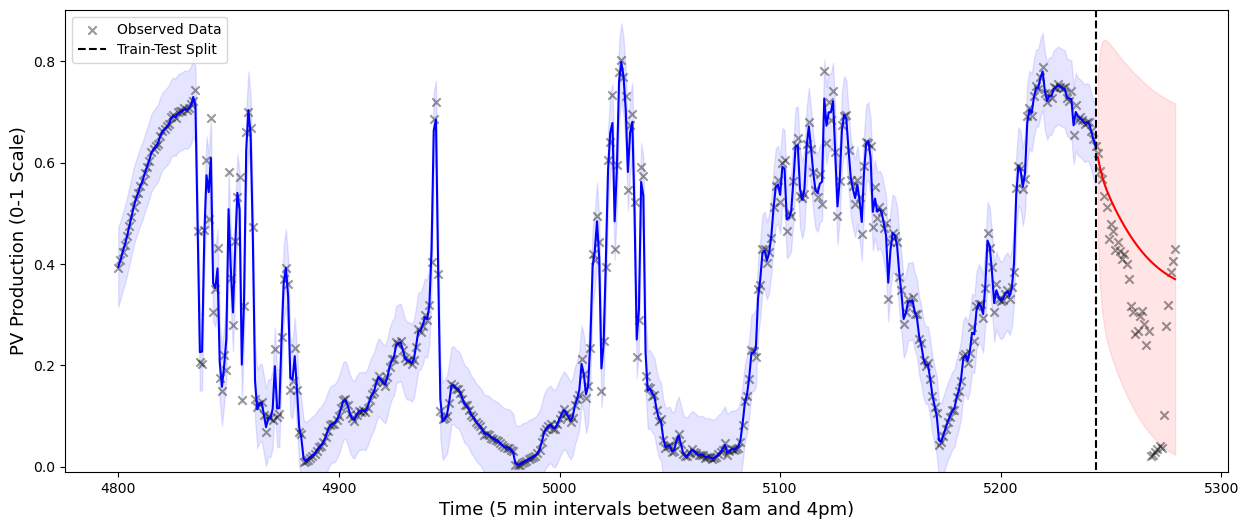

In [676]:
plot_gp(model_exact, x_train, x_test, y_train, y_test)

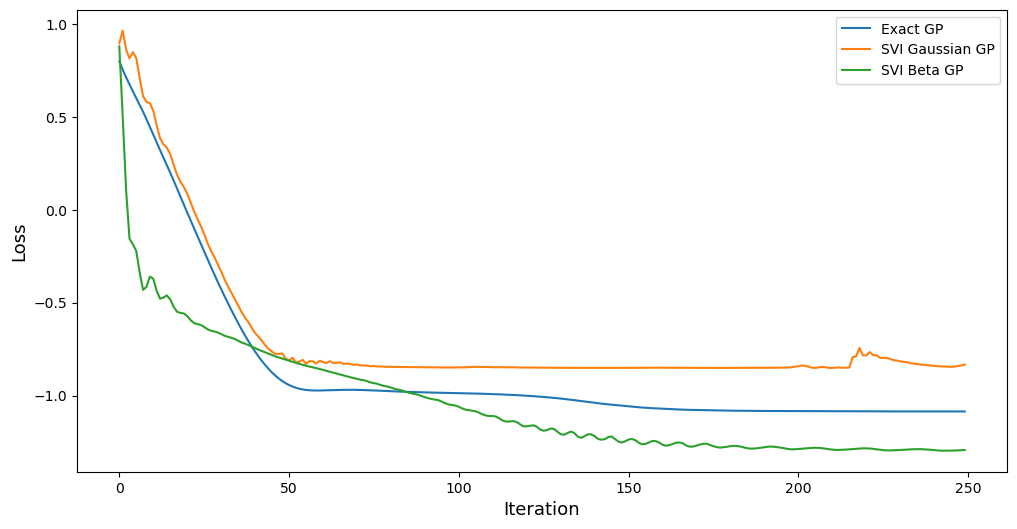

In [677]:
plt.figure(figsize=(12, 6))

plt.plot(model_exact.losses, label='Exact GP')
plt.plot(model_gaussian_svi.losses, label='SVI Gaussian GP')
plt.plot(model_beta.losses, label='SVI Beta GP')

plt.xlabel('Iteration', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend()

# Baselines

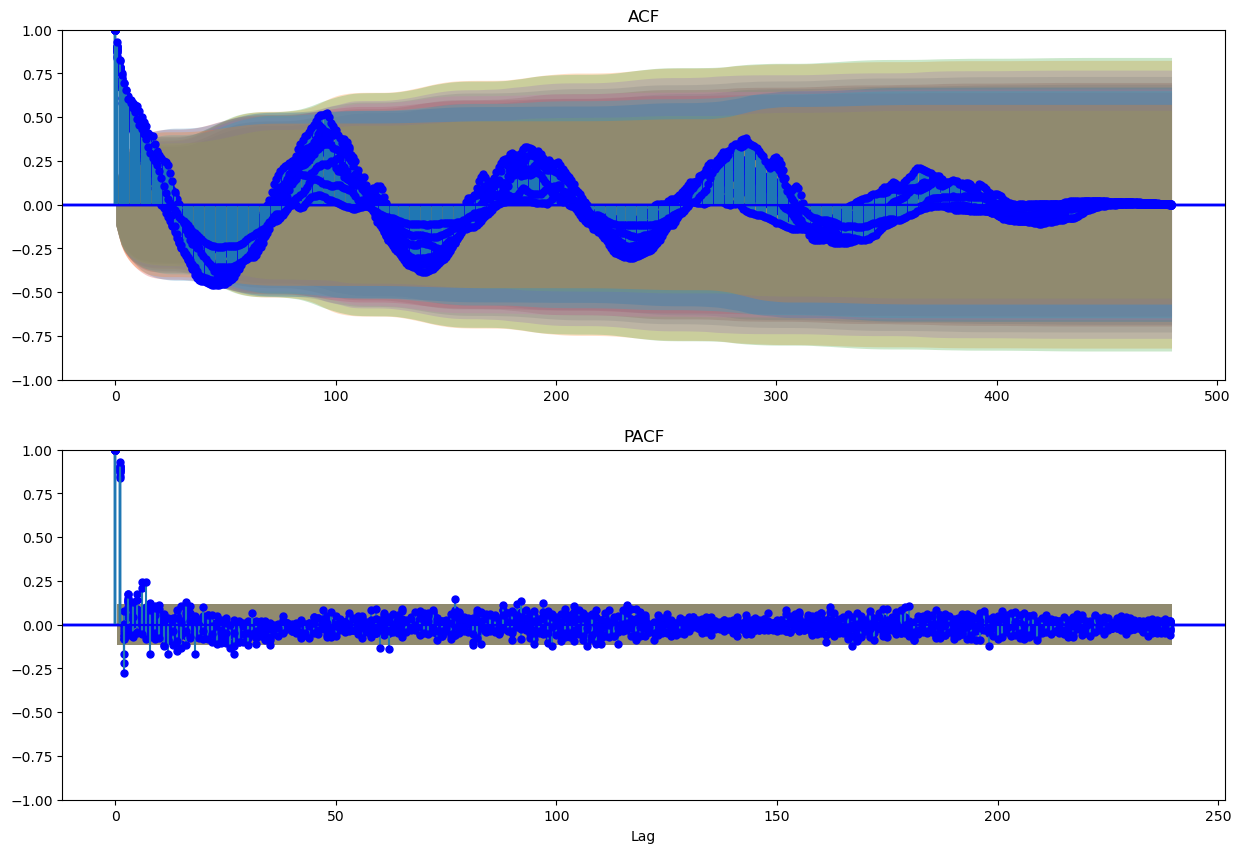

In [66]:
# create function for plotting acf and pacf for all systems in a grid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(y):
    """
    Plot the acf and pacf for all systems in a grid
    """
    _, ax = plt.subplots(2, 1, figsize=(15, 10))
    for i in range(y.shape[1]):
        plot_acf(y[:, i], ax=ax[0], alpha=0.01, lags=len(y) - 1, title='ACF', color='b')
        plot_pacf(y[:, i], ax=ax[1], alpha=0.01, lags=len(y) // 2 - 1, title='PACF', color='b', method='ywm')
    
    plt.xlabel('Lag')
    
    plt.show()

plot_acf_pacf(y)
    


# TODO!! Decide how to use ACF / PACF on selecting amount of data to GP Model & Time Series Models

In [419]:
from statsmodels.tsa.api import AutoReg, ARIMA, SARIMAX, ExponentialSmoothing, MarkovAutoregression


class BaseLineModels:
    """ 
    Global class for time series forecasting models
    
    Args:
        time_train (torch.Tensor): training time
        y_train (torch.Tensor): training data
        time_test (torch.Tensor): test time
        y_test (torch.Tensor): test data
    """
    def __init__(self, time_train, y_train, time_test, y_test):
        self.time_train = time_train
        self.y_train = y_train
        self.time_test = time_test
        self.y_test = y_test
    
    def exponential_smoothing(self, **kwargs):
        """
        Exponential smoothing model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def arima(self, **kwargs):
        """
        ARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarima(self, **kwargs):
        """
        SARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarimax(self, **kwargs):
        """
        SARIMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def var(self, **kwargs):
        """
        VAR model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def varmax(self, **kwargs):
        """
        VARMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    

In [425]:
class ExponentialModels(ExponentialSmoothing):
    """ 
    Global class for exponential smoothing models

    Args:
        time_train (torch.Tensor): training time
        y_train (torch.Tensor): training data
        time_test (torch.Tensor): test time
        y_test (torch.Tensor): test data
    """
    def __init__(self, y_train, y_test, trend):
        super(ExponentialModels, self).__init__(y_train, trend=trend)
        self.y_train = y_train
        self.y_test = y_test
    
    def single_exponential_smoothing(self, alpha : float = 0.2):
        """
        Single exponential smoothing model
        
        Args:
            alpha (float): smoothing parameter
        """
        self.fit(smoothing_level=alpha, optimized=False)
        return self.forecast(len(self.y_test))
    
    def double_exponential_smoothing(self, alpha : float = 0.2, beta : float = 0.2, trend : str = 'add'):
        """
        Double exponential smoothing model
        
        Args:
            alpha (float): smoothing parameter for level
            beta (float): smoothing parameter for trend
            trend (str): type of trend to use
        """
        assert trend in ['add', 'mul'], 'trend must be either add or mul'

        self.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False, use_brute=True)
        return self.forecast(len(self.y_test))
    


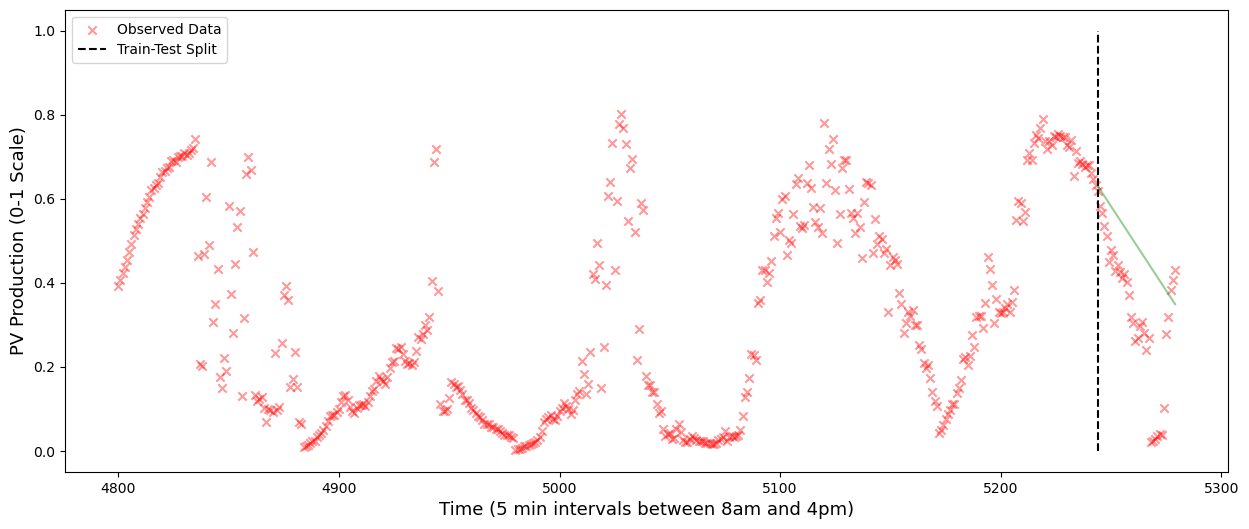

In [456]:
test = y_train[:, 6].numpy().shape

exp_model = ExponentialSmoothing(endog=y_train[:, 6].numpy(),
                                 trend='add',
                                 )
exp_model.fit(smoothing_level=0.2, smoothing_trend=0.2, optimized=False, use_brute=True)
y_pred = exp_model.predict(params=exp_model.params, start=len(y_train), end=len(y_test) + len(y_train) - 1)

plt.figure(figsize=(15, 6))
plt.scatter(time_train, y_train[:, 6], color='r', alpha=0.4, marker = 'x', label='Observed Data')
plt.scatter(time_test, y_test[:, 6], color='r', alpha=0.4, marker = 'x')

plt.vlines(x=len(y_train[:,0]) + time_train.min(), ymin=0, ymax=1, color='black', linestyle='--', label='Train-Test Split')
plt.plot(time_test, y_pred, color='g', alpha=0.4)

plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
plt.ylabel('PV Production (0-1 Scale)', fontsize=13)

plt.legend(loc='upper left')

In [427]:
model = ExponentialModels(y_train=y_train[:, idx].numpy(),
                          y_test=y_test[:, idx].numpy(),
                          trend ='add')

preds = model.single_exponential_smoothing(alpha=0.2)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'